# BRICSを使った構造生成

In [1]:
import pandas as pd
df = pd.read_csv('../data/delaney-solubility/delaney-processed.csv')

In [2]:
from rdkit.Chem import MolFromSmiles
from rdkit import Chem 
import rdkit 
print(rdkit.__version__)
df['mol'] = df['smiles'].apply(MolFromSmiles)

2023.03.1


In [3]:
from rdkit.Chem import BRICS, Recap

In [4]:
print('1個目の分子からBRICSにより見つかるフラグメントの数', len(BRICS.BRICSDecompose(df['mol'][0])))

1個目の分子からBRICSにより見つかるフラグメントの数 6


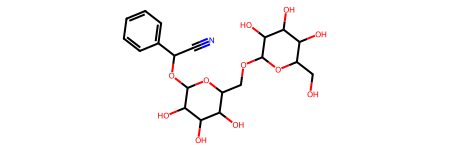

In [5]:
df['mol'][0]

In [6]:
def recursive_retreive(list_fragments, leaf):
    if leaf.children:
        for leaf in leaf.children.values():
            list_fragments += leaf.smiles
            recursive_retreive(list_fragments, leaf)
decomp = Recap.RecapDecompose(df['mol'][0])
lst_frg = []
recursive_retreive(lst_frg, decomp)
print('1個目の分子からRECAPにより再帰的に見つかるフラグメントの数', len(set(lst_frg)))

1個目の分子からRECAPにより再帰的に見つかるフラグメントの数 10


## BRICSを使ったフラグメントライブラリ作成

In [7]:
fragments = [list(BRICS.BRICSDecompose(mol)) for mol in df['mol']]

In [8]:
def unwrap(list_data):
    list_output = []
    for li in list_data: 
        list_output += li
    return list_output 
fr_all = unwrap(fragments)
print('BRICSが取り出した全フラグメント', len(set(fr_all)))

BRICSが取り出した全フラグメント 1028


In [9]:
import random 
random.seed(42)
list_fragments = [MolFromSmiles(smi)for smi in fr_all]
random.shuffle(list_fragments,
               random=random.random)
seed_structures = list_fragments[:2]
print(len(seed_structures))

2


C:\Users\Matsunami\AppData\Local\Temp\ipykernel_5204\817244660.py:4: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(list_fragments,


In [10]:
from tqdm import tqdm
for depth in tqdm(range(1, 3)):
    res = BRICS.BRICSBuild([MolFromSmiles(smi)for smi in fr_all[:100]],
                           maxDepth=depth,
                           seeds = seed_structures) 
    print('作られた構造の数', len(list(res)))

 50%|██████████████████████████████████████████                                          | 1/2 [00:03<00:03,  3.56s/it]

作られた構造の数 572


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:26<00:00, 73.44s/it]

作られた構造の数 11004


In [12]:
print('反応テンプレートの数', len(BRICS.reverseReactions))

反応テンプレートの数 46


## 実行結果について

### BRICSBuildの入力

|引数||
|:---|:---|
|fragments(第一引数)|ダミー原子を1箇所以上含むフラグメント。Molオブジェクトを持つ配列(list)として入力する。|
|seeds|フラグメントのうち、必ず含んでいて欲しい構造。|
|maxDepth|何回結合させるか|

